In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [12]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [13]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for the matching dates from a previous year in the data set
results, = calc_temps('2015-08-01', '2015-08-07')
print(results)

(69.0, 78.27272727272727, 85.0)


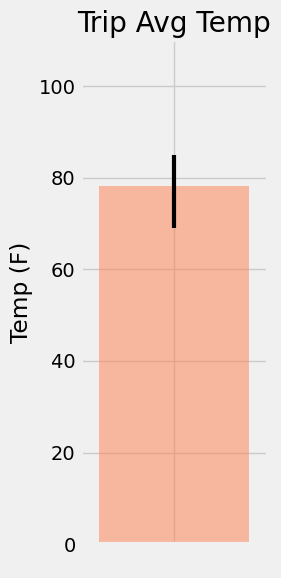

In [14]:
# Plot the results from your previous query as a bar chart. 
plt.rcParams['figure.figsize'] = (3, 6)

# Use the average temperature for bar height (y value)
plt.bar(' ', results[1], color='coral', alpha=0.5)

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower_err = [results[1] - results[0]]
upper_err = [results[2] - results[1]]
error = [lower_err, upper_err]
plt.errorbar(' ', results[1], yerr=error, ecolor='black', elinewidth=3)

# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp')

# Set other graph elements & display results
plt.xlim(-0.5, 0.5)
plt.ylim(0, 110)
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.show()


### Daily Rainfall Average

In [15]:
# Store variables for dates matching the previous year from your trip
start_date = '2016-08-01'
end_date = '2016-08-07'

# Store a list of the columns we will be querying
selection = [func.sum(Measurement.prcp), Measurement.station, Station.name, Station.latitude, 
                Station.longitude, Station.elevation]

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
rainfall = session.query(*selection).filter(selection[1] == Station.station)\
    .filter(Measurement.date >= start_date).filter(Measurement.date <= end_date)\
    .group_by(selection[1]).order_by(selection[0].desc())

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
tot_prcp = pd.DataFrame(rainfall, columns=['Total Precipitation', 'Station', 'Station Name', 
    'Latitude', 'Longitude', 'Elevation'])
tot_prcp

,Total Precipitation,Station,Station Name,Latitude,Longitude,Elevation
0,6.02,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,4.65,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,3.59,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,1.30,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,1.03,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,0.57,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,0.18,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


### Daily Temperature Normals

In [16]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [17]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
sd = dt.datetime.strptime(start_date, '%Y-%m-%d')
ed = dt.datetime.strptime(end_date, '%Y-%m-%d')

trip_dates = [(sd + dt.timedelta(days=x)).date() for x in range((ed - sd).days + 1)]

# Strip off the year and save a list of strings in the format %m-%d
days = [dt.datetime.strftime(x, '%m-%d') for x in trip_dates]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for day in days:
    normals.append(daily_normals(day)[0])

normals


[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [18]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df2 = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df2['Trip Dates'] = trip_dates
trip = df2.set_index('Trip Dates')
trip

,tmin,tavg,tmax
Trip Dates,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


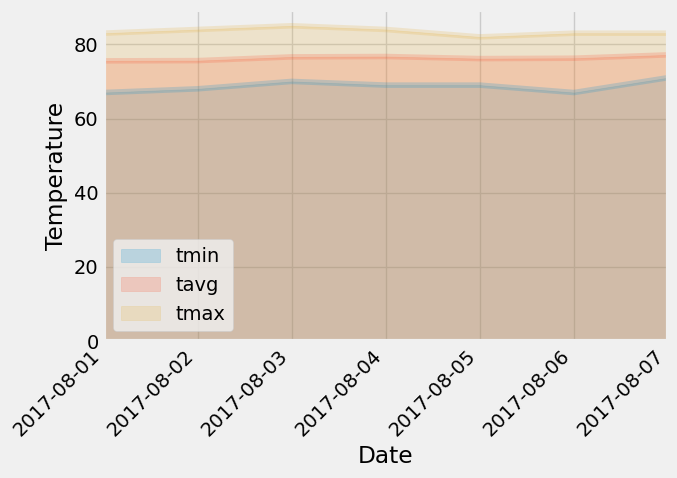

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
trip.plot(kind='area', stacked=False, figsize=(7, 5), alpha=0.2)
plt.xticks(trip.index, trip.index, rotation=45, ha='right')
plt.xlim(trip.index[0], trip.index[-1])
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

## Close Session

In [20]:
session.close()